In [210]:
import mysql.connector as connection
import pandas as pd
import sys
sys.path.append('/Users/eavallon/Desktop/APA/shelterluv_cache/')
import sl_config
import matplotlib.pyplot as plt
import collections
import numpy as np

In [217]:
dbdw =connection.connect(host=sl_config.dbhost,user=sl_config.dbuser,passwd=sl_config.dbpassword,database=sl_config.database)

In [218]:
query = """select e.EventType                                                                           AS EventType,
       e.EventSubtype                                                                        AS EventSubtype,
       date_format(from_unixtime(e.EventTime),'%Y-%m-%d')                                    AS EventDate,
       if(e.EventType like 'Intake%',1,0) AS IntakeMetric,
        if(e.EventType like 'Outcome%',1,0) AS OutcomeMetric,
       a.AnimalID                                                                            AS AnimalID,
       IF(a.AnimalBreed like '%Pit Bull%' or a.AnimalBreed like '%American Staffordshire%',
           'Bully Breed', a.AnimalBreed) as AnimalBreed,
       ifnull(`breed`.`BreedSize`, 'UNKNOWN')                                     AS `BreedSize`,
       laststatuspreoutcome.AnimalStatus,
       laststatuspreoutcome.Location AS LastLocationBeforeOutcome,
       FX_AGEDAYSTOAGEGROUP(to_days(from_unixtime(e.EventTime)) -
                              to_days(from_unixtime(a.AnimalDOBUnixTime)))                   AS IntakeAgeGroup,
       partner.PartnerName                                                                   AS PartnerName,
       partner.ZipCode                                                                       AS PartnerZipCode,
       people.PersonID                                                                       AS PersonID,
       people.PersonZip                                                                      AS PersonZipCode,
       if(abs(to_days(firstintakeevent.FirstIntakeEventTime) -
              to_days(firstfosterevent.FirstFosterEventTime)) < 2, 1,
          0)                                                                                 AS IsDirectToFosterIntake,
       attr.IsDistemper                                                                      AS IsDistemper,
       attr.EverDistemper                                                                    AS EverDistemper,
       attr.IsHospiceFoster                                                                  AS IsHospiceFoster,
       attr.EverHospiceFoster                                                                AS EverHospiceFoster,
       attr.IsParvoWatch                                                                     AS IsParvoWatch,
       attr.EverParvoWatch                                                                   AS EverParvoWatch,
       attr.IsDistemperExposed                                                               AS IsDistemperExposed,
       attr.EverDistemperExposed                                                             AS EverDistemperExposed,
       attr.IsMedicalConsult                                                                 AS IsMedicalConsult,
       attr.EverMedicalConsult                                                               AS EverMedicalConsult,
       attr.IsBehaviorConsult                                                                AS IsBehaviorConsult,
       attr.EverBehaviorConsult                                                              AS EverBehaviorConsult,
       attr.IsHWPos                                                                          AS IsHWPos,
       attr.EverHWPos                                                                        AS EverHWPos,
       attr.IsRW                                                                             AS IsRW,
       attr.EverRW                                                                           AS EverRW,
       attr.IsNeonate                                                                        AS IsNeonate,
       attr.EverNeonate                                                                      AS EverNeonate,
       attr.IsNursing                                                                        AS IsNursing,
       attr.EverNursing                                                                      AS EverNursing,
       attr.IsParvo                                                                          AS IsParvo,
       attr.EverParvo                                                                        AS EverParvo,
       attr.IsPreadoptionTraining                                                            AS IsPreadoptionTraining,
       attr.EverPreadoptionTraining                                                          AS EverPreadoptionTraining,
       attr.IsBiteHistory                                                                    AS IsBiteHistory,
       attr.IsResourceGuarder                                                                AS IsResourceGuarder,
       attr.IsOnLeashReactive                                                                AS IsOnLeashReactive,
       attr.IsDefensiveAggression                                                            AS IsDefensiveAggression,
       attr.IsHandlerGuarding                                                                AS IsHandlerGuarding,
       attr.IsTerritorialAggression                                                          AS IsTerritorialAggression,
       attr.IsOverArousal                                                                    AS IsOverArousal,
       attr.IsFlightRisk                                                                     AS IsFlightRisk
from shelterluv.Events e
left join shelterluv.Animals a on e.`AnimalInternal-ID` = a.`AnimalInternal-ID`
left join shelterluv.Partners partner  on (e.`PartnerInternal-ID` = partner.`PartnerInternal-ID`)
left join shelterluv.People people on (e.`PartnerInternal-ID` = people.`PersonInternal-ID`)
left join `datawarehouse`.`SL_AnimalsBreeds` `breed` on (`a`.`AnimalBreed` = `breed`.`AnimalBreed`)
left join (select ah.`AnimalInternal-ID` AS `AnimalInternal-ID`,
                  max(if(ah.AttributeName = 'Distemper' and ah.DateEnd is null, 1, 0))  AS IsDistemper,
                  max(if(ah.AttributeName = 'Distemper', 1, 0))                          AS EverDistemper,
                  max(if(ah.AttributeName = 'Distemper watch' and ah.DateEnd is null, 1, 0)) AS EverDistemperWatch,
                  max(if(ah.AttributeName = 'Hospice foster' and ah.DateEnd is null, 1, 0)) AS IsHospiceFoster,
                  max(if(ah.AttributeName = 'Hospice foster', 1, 0))                     AS EverHospiceFoster,
                  max(if(ah.AttributeName = 'Parvo watch' and ah.DateEnd is null, 1, 0)) AS IsParvoWatch,
                  max(if(ah.AttributeName = 'Parvo watch', 1, 0))                        AS EverParvoWatch,
                  max(if(ah.AttributeName = 'Distemper exposed' and ah.DateEnd is null, 1, 0)) AS IsDistemperExposed,
                  max(if(ah.AttributeName = 'Distemper exposed', 1, 0))                  AS EverDistemperExposed,
                  max(if( ah.AttributeName like 'Medical Consult%' and ah.DateEnd is null, 1, 0)) AS IsMedicalConsult,
                  max(if(ah.AttributeName like 'Medical Consult%', 1, 0))                AS EverMedicalConsult,
                  max(if( ah.AttributeName like 'Behavior Consult%'
                              and ah.DateEnd is null, 1, 0))                             AS IsBehaviorConsult,
                  max(if(ah.AttributeName like 'Behavior Consult%', 1, 0))               AS EverBehaviorConsult,
                  max(if(ah.AttributeName = 'Heartworm +' and
                         ah.DateEnd is null,
                         1,
                         0))                                                                 AS IsHWPos,
                  max(if(ah.AttributeName = 'Heartworm +', 1, 0))                        AS EverHWPos,
                  max(if(ah.AttributeName in('Ringworm +', 'Ringworm') and
                         ah.DateEnd is null,
                         1,
                         0))                                                                 AS IsRW,
                  max(if(ah.AttributeName in ('Ringworm +',
                          'Ringworm',
                          'Ringworm Graduate'),
                         1,
                         0))                                                                 AS EverRW,
                  max(if(ah.AttributeName = 'Neonate' and ah.DateEnd is null, 1, 0)) AS IsNeonate,
                  max(if(ah.AttributeName = 'Neonate', 1, 0))                            AS EverNeonate,
                  max(if(ah.AttributeName =
                         'Nursing Mom' and
                         ah.DateEnd is null,
                         1,
                         0))                                                                 AS IsNursing,
                  max(if(ah.AttributeName = 'Nursing Mom', 1, 0))                        AS EverNursing,
                  max(if(ah.AttributeName = 'Parvo' and ah.DateEnd is null, 1, 0))   AS IsParvo,
                  max(if(ah.AttributeName = 'Parvo', 1, 0))                              AS EverParvo,
                  max(if(ah.AttributeName in
                         ('Preadoption training required',
                          'Pre-adoption and post-adoption training required') and
                         ah.DateEnd is null,
                         1,
                         0))                                                                 AS IsPreadoptionTraining,
                  max(if(ah.AttributeName in
                         ('Preadoption training required',
                          'Pre-adoption and post-adoption training required'),
                         1,
                         0))                                                                 AS EverPreadoptionTraining,
                  max(if(
                                  ah.AttributeName like
                                  'Bite History%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsBiteHistory,
                  max(if(
                                  ah.AttributeName like
                                  'Resource Guarder%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsResourceGuarder,
                  max(if(
                                  ah.AttributeName like
                                  'On Leash Reactivity%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsOnLeashReactive,
                  max(if(
                                  ah.AttributeName like
                                  'Defensive Aggression%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsDefensiveAggression,
                  max(if(
                                  ah.AttributeName like
                                  'Handler Guarding%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsHandlerGuarding,
                  max(if(
                                  ah.AttributeName like
                                  'Territorial Aggression%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsTerritorialAggression,
                  max(if(
                                  ah.AttributeName like
                                  'Over Arousal%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsOverArousal,
                  max(if(
                                  ah.AttributeName like
                                  'Flight Risk%' and
                                  ah.DateEnd is null,
                                  1,
                                  0))                                                        AS IsFlightRisk
           from shelterluv.AnimalsAttributesHistory ah
           group by ah.`AnimalInternal-ID`) attr
         on (a.`AnimalInternal-ID` = attr.`AnimalInternal-ID`)
left join shelterluv.EventTypes et on (concat(e.EventType, '.', e.EventSubtype) = et.EventTypeSubType)
left join (select * from (select shelterluv.Events.EventID                                                                                                                                  AS EventID,
                                  shelterluv.Events.EventType                                                                                                                                AS EventType,
                                  from_unixtime(shelterluv.Events.EventTime)                                                                                                                 AS FirstIntakeEventTime,
                                  shelterluv.Events.`AnimalInternal-ID`                                                                                                                       AS `AnimalInternal-ID`,
                                  row_number() over ( partition by shelterluv.Events.`AnimalInternal-ID`
                                      order by shelterluv.Events.`AnimalInternal-ID`,shelterluv.Events.EventTime) AS RowNum
                           from shelterluv.Events
                           where shelterluv.Events.EventType like 'Intake%') rn
            where rn.RowNum = 1) firstintakeevent on (e.`AnimalInternal-ID` = firstintakeevent.`AnimalInternal-ID`
                                                          and e.EventID = firstintakeevent.EventID)
left join (select * from (select shelterluv.Events.EventType AS EventType,
                                 from_unixtime(shelterluv.Events.EventTime) AS FirstFosterEventTime,
                                 shelterluv.Events.`AnimalInternal-ID` AS `AnimalInternal-ID`,
                                 row_number() over ( partition by shelterluv.Events.`AnimalInternal-ID`
                                                        order by shelterluv.Events.`AnimalInternal-ID`,shelterluv.Events.EventTime) AS RowNum
                         from shelterluv.Events
                         where shelterluv.Events.EventType = 'Outcome.Foster') rn
                         where rn.RowNum = 1) firstfosterevent on (e.`AnimalInternal-ID` = firstfosterevent.`AnimalInternal-ID`)
left outer join (select *
           from (select ash.`AnimalInternal-ID`,
                        ash.AnimalStatus,
                        row_number() over (partition by ash.`AnimalInternal-ID`
                                           order by ash.`AnimalInternal-ID`,
                                                    ash.DateStart DESC) AS RowNum,
                        st.Location
                from shelterluv.AnimalsStatusHistory ash
                LEFT JOIN shelterluv.StatusTypes st ON ash.AnimalStatus=st.AnimalStatus
                where ash.AnimalStatus like '%vailable%') rn
                where rn.RowNum = 1) laststatuspreoutcome on (e.`AnimalInternal-ID` = laststatuspreoutcome.`AnimalInternal-ID` and e.EventType like 'Outcome%')
where e.EventType in ('Intake.AdoptionReturn',
                        'Intake.BornInCare',
                        'Intake.OwnerSurrender',
                        'Intake.Transfer',
                        'Intake.Service',
                        'Intake.Stray',
                        'Outcome.Adoption',
                        'Outcome.Euthanasia',
                        'Outcome.FeralWildlife',
                        'Outcome.Lost',
                        'Outcome.ReturnToOwner',
                        'Outcome.Service',
                        'Outcome.Transfer',
                        'Outcome.UnassistedDeathInCustody')
and a.AnimalType = 'Dog'
and BreedSize = 'LargeMedium'
and from_unixtime(EventTime)>'2021-01-01 00:00:00.0'"""

In [219]:
ldio = pd.read_sql(query,dbdw)

In [220]:
intakes = ldio[ldio['IntakeMetric']==1]
outcomes = ldio[ldio['OutcomeMetric']==1]

In [226]:
in_cts = np.array(list(collections.Counter(intakes['EventDate']).values()))
in_dates = np.array(list(collections.Counter(intakes['EventDate']).keys()))
out_cts = np.array(list(collections.Counter(outcomes['EventDate']).values()))
out_dates = np.array(list(collections.Counter(outcomes['EventDate']).keys()))

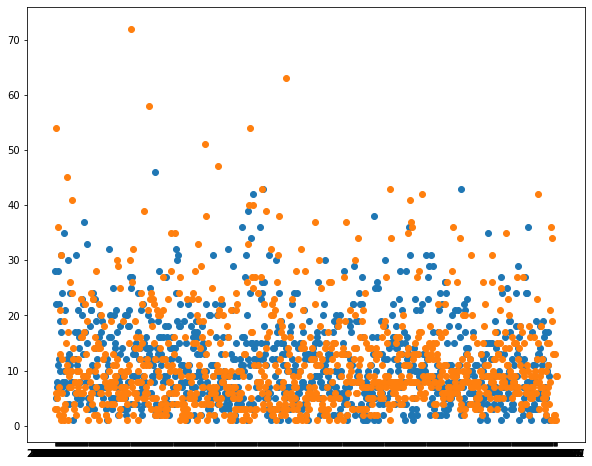

In [231]:
plt.figure(figsize=(10,8))
plt.scatter(in_dates,in_cts)
plt.scatter(out_dates,out_cts)